https://github.com/Jpub/AlphaZero/blob/master/6_7_tictactoe/evaluate_network.py

# State

In [ ]:
import numpy as np

class State:
    def __init__(self, board_size=3, pieces=None, enemy_pieces=None):
        self.board_size = board_size
        self.pieces = np.zeros(board_size * board_size, dtype=int) if pieces is None else np.array(pieces)
        self.enemy_pieces = np.zeros(board_size * board_size, dtype=int) if enemy_pieces is None else np.array(enemy_pieces)

    def piece_count(self, pieces):
        return np.sum(pieces)

    def is_lose(self):
        board = self.enemy_pieces.reshape(self.board_size, self.board_size)

        return any(
            np.all(line == 1) for line in
            np.vstack([
                board,  # 행
                board.T,  # 열
                np.diag(board),  # 대각선
                np.diag(np.fliplr(board))  # 반대 대각선
            ])
        )

    def is_draw(self):
        return self.piece_count(self.pieces) + self.piece_count(self.enemy_pieces) == self.board_size * self.board_size

    def is_done(self):
        # 종료 조건: 상대방이 승리 or 무승부
        return self.is_lose() or self.is_draw()

    def next(self, action):
        # 현재 상태에서 주어진 action(칸)에 말을 놓은 후 다음 상태 반환
        pieces = self.pieces.copy()
        pieces[action] = 1
        return State(self.board_size, self.enemy_pieces, pieces)

    def legal_actions(self):
        # 가능한 행동(빈 칸의 위치)을 반환
        return np.where((self.pieces + self.enemy_pieces) == 0)[0]

    def to_feature(self):
        # 상태를 신경망 입력 형태로 변환 (2, board_size, board_size)
        return np.stack([
            self.pieces.reshape(self.board_size, self.board_size),
            self.enemy_pieces.reshape(self.board_size, self.board_size)
        ], axis=0)

    def __str__(self):
        ox = ('o', 'x') if np.sum(self.pieces) == np.sum(self.enemy_pieces) else ('x', 'o')
        board = np.full(self.board_size * self.board_size, '-')
        board[self.pieces == 1] = ox[0]
        board[self.enemy_pieces == 1] = ox[1]
        return '\n'.join([
            ''.join(board[i:i + self.board_size]) for i in range(0, self.board_size * self.board_size, self.board_size)
        ])

# Dual Network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, n_filters=128):
        super().__init__()
        self.conv1 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(n_filters)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(n_filters)

    def forward(self, x):
        shortcut = x # 잔차
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        return F.relu(x + shortcut)

class DualNetwork(nn.Module):
    def __init__(self, board_size, input_channels=2, n_filters=128, n_res_blocks=16):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, n_filters, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(n_filters)
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(n_filters) for _ in range(n_res_blocks)]
        )
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # policy
        self.policy_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_filters, board_size * board_size),
            nn.Softmax(dim=1)
        )
        # value
        self.value_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_filters, 1),
            nn.Tanh()
        )

    def forward(self, x):
        # input x : (배치 크기, 채널, 보드 크기, 보드 크기)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.res_blocks(x)
        x = self.global_pool(x)
        policy = self.policy_head(x)
        value = self.value_head(x)
        return policy, value

# MCTS

In [ ]:
C_PCUT = 1.25 # 탐험과 탐욕적 행동 선택 균형
PV_EVALUATE_COUNT = 10

In [ ]:
from math import sqrt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 추론
def predict(model, state, board_size):
    # 입력 데이터 정규화
    x = np.array([state.pieces, state.enemy_pieces], dtype=np.float32) / 1.0 # np.array로 해놓고 torch.float32으로 함..
    x = x.reshape(2, board_size, board_size).transpose(0, 1, 2).reshape(1, 2, board_size, board_size)
    x = torch.tensor(x, dtype=torch.float32).to(device)

    with torch.no_grad():
        policy, value = model(x) # 신경망으로 정책 및 가치 예측
        policy = policy.cpu().numpy().flatten()
        value = value.cpu().numpy().flatten()

    legal_actions = state.legal_actions()
    policies = policy[legal_actions]
    policy_sum = policies.sum()
    if policy_sum > 0:
        policies /= policy_sum
    else:
        policies = np.ones_like(policies) / len(policies)
    return policies, value[0]

class MCTSNode:
    def __init__(self, state, p, c_puct=C_PCUT):
        self.state = state
        self.p = p # 신경망에서 예측한 정책 확률
        self.w = 0 # 노드 누적 보상
        self.n = 0 # 노드 방문 횟수
        self.c_puct = c_puct
        self.child_nodes = None

    def evaluate(self, model):
        # 1
        if self.state.is_done(): # 종료 상태인지 확인
            value = -1 if self.state.is_lose() else 0 # 패배: -1, 무승부: 0
            # 보상 누계와 시행 횟수 갱신
            self.w += value
            self.n += 1
            return value
        # 2
        # 자식 노드가 존재하지 않는 경우
        if not self.child_nodes:
            # 신경망으로 정책 및 가치 예측
            policies, value = predict(model, self.state, self.state.board_size)
            # 보상 누계와 시행 횟수 갱신
            self.w += value
            self.n += 1
            # 자식 노드 전개(확장)
            self.child_nodes = []
            for action, policy in zip(self.state.legal_actions(), policies):
              self.child_nodes.append(MCTSNode(self.state.next(action), policy, c_puct = self.c_puct))
            return value
        # 3
        else:
            # UCB1이 가장 큰 자식 노드를 평가해 가치 얻기
            # 탐색-활용(Exploration-Exploitation) 균형 전략 중 하나
            value = -self.next_child_node().evaluate(model)
            # 보상 누계와 시행 횟수 갱신
            self.w += value
            self.n += 1
            return value

    # Upper Confidence Bound1
    def next_child_node(self):
        # 공식
        t = sum(child.n for child in self.child_nodes)
        pucb_values = []
        for child_node in self.child_nodes:
          pucb_values.append((-child_node.w/child_node.n if child_node.n else 0.0)+
                             self.c_puct * child_node.p * sqrt(t) / (1 + child_node.n))
        return self.child_nodes[np.argmax(pucb_values)] # 최대값 출력

# 노드 리스트를 시행 횟수 리스트로 변환
def nodes_to_scores(nodes):
    return [node.n for node in nodes]

# 볼츠만 분포 계산
def boltzman(xs, temperature):
    xs = [x ** (1 / temperature) for x in xs]
    return [x / sum(xs) for x in xs]

# 몬테카를로 트리 탐색
def pv_mcts_scores(model, state, temperature):
    # 현재 상태의 루트 노드 생성
    root_node = MCTSNode(state, 0)

    # 시뮬레이션 반복 실행
    for _ in range(PV_EVALUATE_COUNT):
        root_node.evaluate(model)

    # 자식 노드 방문 횟수를 점수로 변환
    scores = nodes_to_scores(root_node.child_nodes)

    if temperature == 0: # 최대값인 경우에만 1
        action = np.argmax(scores)
        scores = np.zeros(len(scores))
        scores[action] = 1
    else:
        scores = boltzman(scores, temperature) # 볼츠만 분포를 기반으로 분산 추가
    return scores


# 몬테카를로 트리 탐색을 활용한 행동 선택
def pv_mcts_action(model, temperature=0):
    def action_selector(state):
        scores = pv_mcts_scores(model, state, temperature) # 각 행동에 대한(상태에 기반) 확률분포 계산
        return np.random.choice(state.legal_actions(), p=scores) # 하나의 행동을 확률적으로 선택
    return action_selector

def mcts_simulation(root_node, model, simulations=100):
    for _ in range(simulations):
        root_node.evaluate(model)
    # 방문 횟수 기준 정책 계산
    child_visits = [child.n for child in root_node.child_nodes]
    policy = np.array(child_visits) / sum(child_visits)
    return root_node, policy # 현재 게임 상태, 정책

# self play

In [ ]:
def self_play_game(model, board_size=3, simulations=100, temperature=0):
    state = State(board_size=board_size)
    game_data = []

    while not state.is_done():
        # 현재 상태에서 MCTS 기반 점수 계산
        scores = pv_mcts_scores(model, state, temperature)

        # 점수를 고정 크기 정책으로 변환
        ''' 이유
         정책 벡터가 보드의 크기와 맞춰지고, 유효한 행동만 확률로 유지'''

        full_policy = np.zeros(board_size * board_size, dtype=np.float32)
        legal_actions = state.legal_actions()  # 유효한 행동 리스트
        full_policy[legal_actions] = scores
        game_data.append((state.to_feature(), full_policy))

        # 확률적으로 행동 선택
        action = np.random.choice(state.legal_actions(), p=scores)
        state = state.next(action)

    # 게임 종료 후 보상 계산
    reward = 1 if not state.is_lose() else -1
    game_data = [(s, p, reward) for s, p in game_data]
    return game_data

# Train Model

In [ ]:
def train_model(model, scheduler, optimizer, game_data, epochs=1, batch_size=64):
    model.train()
    loss_fn_policy = torch.nn.CrossEntropyLoss()
    loss_fn_value = torch.nn.MSELoss()

    # 데이터를 PyTorch 텐서로 변환
    states, policies, values = zip(*game_data)

    states = torch.tensor(states, dtype=torch.float32).to(device)
    policies = torch.tensor(policies, dtype=torch.float32).to(device)
    values = torch.tensor(values, dtype=torch.float32).unsqueeze(1).to(device)

    dataset = torch.utils.data.TensorDataset(states, policies, values)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        total_loss, total_policy_loss, total_value_loss = 0, 0, 0

        for inputs, targets_policy, targets_value in data_loader:
            inputs = inputs.to(device)
            targets_policy = targets_policy.to(device)
            targets_value = targets_value.to(device)

            # 모델예측
            predicted_policies, predicted_values = model(inputs)

            loss_policy = loss_fn_policy(predicted_policies, targets_policy)
            loss_value = loss_fn_value(predicted_values, targets_value)
            loss = loss_policy + loss_value

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_policy_loss += loss_policy.item()
            total_value_loss += loss_value.item()

        # 에포크별 평균 기록
        training_metrics["loss"].append(total_loss / len(data_loader))
        training_metrics["policy_loss"].append(total_policy_loss / len(data_loader))
        training_metrics["value_loss"].append(total_value_loss / len(data_loader))

        scheduler.step() # scheduler는 마지막에

# Evaluate model

In [ ]:
def evaluate_models(new_model, old_model, games=20, board_size=3):
    new_wins, old_wins = 0, 0
    temperature = 1.0

    for _ in range(games):
        state = State(board_size=board_size)
        current_player = new_model

        while not state.is_done():
            scores = pv_mcts_scores(current_player, state, temperature)
            action = np.random.choice(state.legal_actions(), p=scores)
            state = state.next(action)

            # 플레이어 교체
            current_player = old_model if current_player == new_model else new_model

        if state.is_lose():
            if current_player == new_model:
                old_wins += 1
            else:
                new_wins += 1

    # 승리 결과 기록
    evaluation_metrics["new_model_wins"].append(new_wins)
    evaluation_metrics["old_model_wins"].append(old_wins)
    return new_wins, old_wins

# Final

In [ ]:
import matplotlib.pyplot as plt

def plot_graph():
    # 그래프
    plt.figure(figsize=(15, 5))

    # 1. 정책 정확도 그래프
    plt.subplot(1, 3, 1)
    plt.plot(training_metrics["policy_loss"], label="Policy Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Policy Loss Over Epochs")
    plt.legend()

    # 2. 손실 그래프 (전체 손실과 가치 손실)
    plt.subplot(1, 3, 2)
    plt.plot(training_metrics["loss"], label="Total Loss", marker="o")
    plt.plot(training_metrics["value_loss"], label="Value Loss", marker="x")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # 3. 승률 그래프 (새 모델 vs 기존 모델 승리 횟수)
    plt.subplot(1, 3, 3)
    plt.plot(evaluation_metrics["new_model_wins"], label="New Model Wins", marker="o")
    plt.plot(evaluation_metrics["old_model_wins"], label="Old Model Wins", marker="x")
    plt.xlabel("Iterations")
    plt.ylabel("Wins")
    plt.title("Model Evaluation Results")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
BOARD_SIZE = 3
LEARNING_RATE = 1e-3
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
SIMULATIONS = 100
GAMES_PER_ITERATION = 10
EVALUATION_GAMES = 10
ITERATIONS = 50

Iteration 1
New Model Wins: 5, Old Model Wins: 3, Loss: 4.563566207885742, Value Loss: 2.384939432144165
Iteration 2
New Model Wins: 6, Old Model Wins: 3, Loss: 2.3351657390594482, Value Loss: 0.14960156381130219
Iteration 3
New Model Wins: 3, Old Model Wins: 6, Loss: 2.157362461090088, Value Loss: 6.981194746913388e-05
Iteration 4
New Model Wins: 3, Old Model Wins: 6, Loss: 2.115706205368042, Value Loss: 1.0366961511465433e-08
Iteration 5
New Model Wins: 5, Old Model Wins: 4, Loss: 2.048269271850586, Value Loss: 4.367635073054821e-11
Iteration 6
New Model Wins: 6, Old Model Wins: 1, Loss: 1.9316381216049194, Value Loss: 3.900879456692624e-13
Iteration 7
New Model Wins: 8, Old Model Wins: 2, Loss: 1.7752437591552734, Value Loss: 7.105427357601002e-15
Iteration 8
New Model Wins: 10, Old Model Wins: 0, Loss: 1.6445250511169434, Value Loss: 0.0
Iteration 9
New Model Wins: 7, Old Model Wins: 3, Loss: 2.1318752765655518, Value Loss: 0.0
Iteration 10
New Model Wins: 7, Old Model Wins: 3, Los

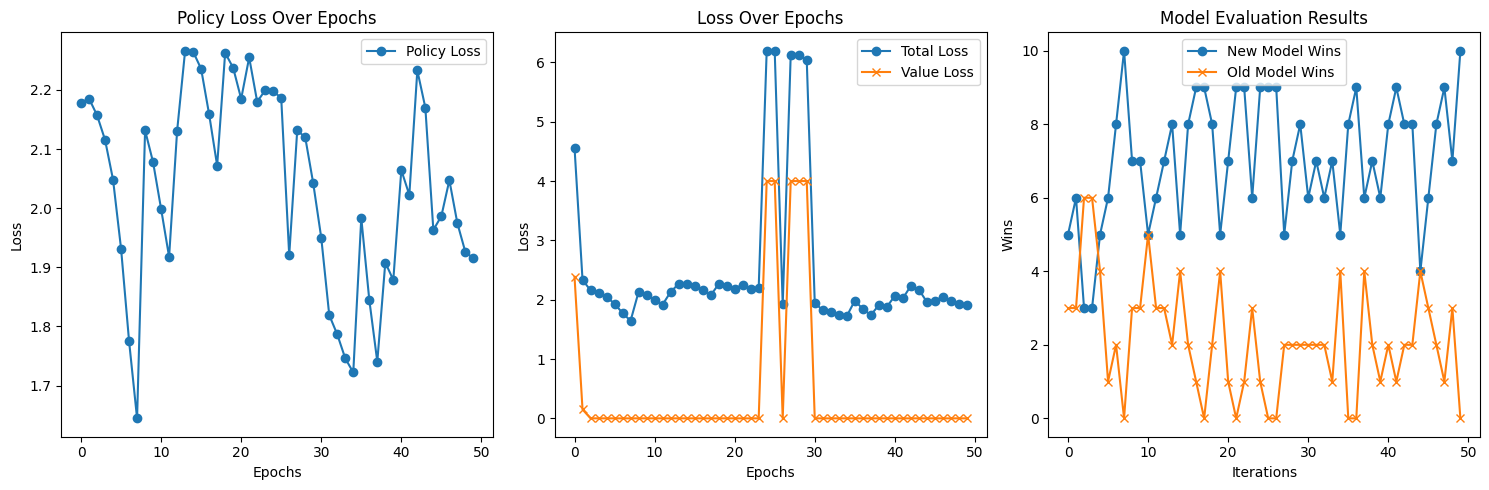

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

model = DualNetwork(BOARD_SIZE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

old_model =  DualNetwork(BOARD_SIZE).to(device)
old_model.load_state_dict(model.state_dict())

training_metrics = {
    "loss": [],
    "policy_loss": [],
    "value_loss": []
}

evaluation_metrics = {
    "new_model_wins": [],
    "old_model_wins": []
}

for iteration in range(ITERATIONS):
    print(f"Iteration {iteration + 1}")
    game_data = []
    for _ in range(GAMES_PER_ITERATION):
        game_data += self_play_game(model, BOARD_SIZE, simulations=SIMULATIONS)
    train_model(model, scheduler, optimizer, game_data, epochs=1)

    new_wins, old_wins = evaluate_models(model, old_model, games=EVALUATION_GAMES)
    last_loss = training_metrics['loss'][-1] # 어떤 행동을 취해야 할지(정책)와 그 상태가 얼마나 좋은지(가치)를 학습
    last_value_loss = training_metrics['value_loss'][-1] # 정확한 승리 확률이나 기대 보상을 예측하도록 학습
    print(f"New Model Wins: {new_wins}, Old Model Wins: {old_wins}, Loss: {last_loss}, Value Loss: {last_value_loss}")

    # if new_wins > old_wins:
    #     old_model.load_state_dict(model.state_dict())
    #     print("New model is better and replaced the old model.")
    # else:
    #     print("Old model is better. Retaining old model.")

plot_graph()